In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import os
import pandas as pd
import librosa
import torch.nn as nn
import torchvision.models as models
import random

torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

In [30]:
!pip3 install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 KB 19.1 MB/s eta 0:00:00


In [ ]:
!nvidia-smi

Tue Apr  4 21:57:22 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    23W / 300W |      0MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [10]:
from google.colab import drive
drive.mount('/content/drive')
working_folder_path = "/content/drive/MyDrive/3YP/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Data set from The universal audio synth, customize into our own use case. Turn the .npz files given to a binary format to increase performance.

## Load the binary file and start our own project

In [3]:
class Mel_dataset(Dataset):
    def __init__(self, inputs, targets):
        self.inputs = inputs
        self.targets = targets

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        input_sample = self.inputs[idx]
        target_sample = self.targets[idx]
        return input_sample, target_sample

In [4]:
def model_test(model):
    test_img = torch.randn(2, 1, 224, 224)
    out = model(test_img)
    print(out.size())

In [5]:
class MLP_L5(nn.Module):
    def __init__(self, input_dim=224**2, hidden_dim=2048, output_dim=32):
        super(MLP_L5, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.bn3 = nn.BatchNorm1d(hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, hidden_dim)
        self.bn4 = nn.BatchNorm1d(hidden_dim)
        self.fc5 = nn.Linear(hidden_dim, hidden_dim)
        self.bn5 = nn.BatchNorm1d(hidden_dim)
        self.fc6 = nn.Linear(hidden_dim, output_dim)
        
        self.elu = nn.ELU()
        self.dropout = nn.Dropout(0.3)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        x = x.reshape(x.size(0), -1)
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.elu(x)
        x = self.dropout(x)

        x = self.fc2(x)
        x = self.bn2(x)
        x = self.elu(x)
        x = self.dropout(x)

        x = self.fc3(x)
        x = self.bn3(x)
        x = self.elu(x)
        x = self.dropout(x)

        x = self.fc4(x)
        x = self.bn4(x)
        x = self.elu(x)
        x = self.dropout(x)

        x = self.fc5(x)
        x = self.bn5(x)
        x = self.elu(x)
        x = self.dropout(x)

        x = self.fc6(x)
        x = self.sigmoid(x)
        return x


In [ ]:
# # unit test/ Passed
# mlp_l5 = MLP()
# test_img = torch.randn(2, 1, 224, 224)
# out = mlp_l5(test_img)
# out.size()

torch.Size([2, 32])

In [ ]:
class CNN_L5_Original(nn.Module):
    def __init__(self):
        super(CNN_L5_Original, self).__init__()

        self.conv1 = nn.Conv2d(1, 128, kernel_size=7, stride=2, padding=3, dilation=1)
        self.bn1 = nn.BatchNorm2d(128)
        self.conv2 = nn.Conv2d(128, 128, kernel_size=7, stride=2, padding=9, dilation=2)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 128, kernel_size=7, stride=2, padding=15, dilation=4)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=7, stride=2, padding=27, dilation=8)
        self.bn4 = nn.BatchNorm2d(128)
        self.conv5 = nn.Conv2d(128, 128, kernel_size=7, stride=2, padding=51, dilation=16)
        self.bn5 = nn.BatchNorm2d(128)
        self.fc1 = nn.Linear(21632, 2048)
        self.bn6 = nn.BatchNorm1d(2048)
        self.fc2 = nn.Linear(2048, 2048)
        self.bn7 = nn.BatchNorm1d(2048)
        self.fc3 = nn.Linear(2048, 32)

        self.sigmoid = nn.Sigmoid()
        self.elu = nn.ELU()
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.elu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.elu(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.elu(x)

        x = self.conv4(x)
        x = self.bn4(x)
        x = self.elu(x)

        x = self.conv5(x)
        x = self.bn5(x)
        x = self.elu(x)

        x = x.reshape(x.size(0), -1)

        x = self.fc1(x)
        x = self.bn6(x)
        x = self.elu(x)
        x = self.dropout(x)

        x = self.fc2(x)
        x = self.bn7(x)
        x = self.elu(x)
        x = self.dropout(x)

        x = self.fc3(x)
        x = self.sigmoid(x)

        return x

model_test(CNN_L5_Original())

torch.Size([2, 32])


In [19]:
class CNN_L5(nn.Module):
    def __init__(self):
        super(CNN_L5, self).__init__()

        self.conv1 = nn.Conv2d(1, 128, kernel_size=5, stride=2, padding=1, dilation=1)
        self.bn1 = nn.BatchNorm2d(128)
        self.conv2 = nn.Conv2d(128, 128, kernel_size=5, stride=2, padding=1, dilation=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 128, kernel_size=5, stride=2, padding=1, dilation=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=5, stride=2, padding=1, dilation=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.conv5 = nn.Conv2d(128, 128, kernel_size=5, stride=2, padding=1, dilation=1)
        self.bn5 = nn.BatchNorm2d(128)
        self.fc1 = nn.Linear(4608, 2048)
        self.bn6 = nn.BatchNorm1d(2048)
        self.fc2 = nn.Linear(2048, 2048)
        self.bn7 = nn.BatchNorm1d(2048)
        self.fc3 = nn.Linear(2048, 32)

        self.sigmoid = nn.Sigmoid()
        self.elu = nn.ELU()
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.elu(x)
        # print(x.size())
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.elu(x)
        # print(x.size())
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.elu(x)
        # print(x.size())
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.elu(x)
        # print(x.size())
        x = self.conv5(x)
        x = self.bn5(x)
        x = self.elu(x)
        # print(x.size())
        x = x.reshape(x.size(0), -1)

        x = self.fc1(x)
        x = self.bn6(x)
        x = self.elu(x)
        x = self.dropout(x)

        x = self.fc2(x)
        x = self.bn7(x)
        x = self.elu(x)
        x = self.dropout(x)

        x = self.fc3(x)
        x = self.sigmoid(x)

        return x

model_test(CNN_L5())

torch.Size([2, 32])


In [ ]:
# # unit test / Passed
# cnn_l5 = CNN_L5(1, 32)
# test_img = torch.randn(2, 1, 224, 224)
# out = cnn_l5(test_img)
# out.size()

torch.Size([2, 32])

In [ ]:
# # do not use, can't resolve the dimension problem of the residual path
# class ResidualBlock(nn.Module):
#     def __init__(self, in_channels, dilation):
#         super(ResidualBlock, self).__init__()

#         self.conv1 = nn.Conv2d(in_channels, 128, kernel_size=7, stride=2, padding=(dilation + 1) * 3, dilation=dilation)
#         self.bn1 = nn.BatchNorm2d(128)
        
#         self.conv2 = nn.Conv2d(in_channels, 128, kernel_size=1, stride=2, padding=(dilation + 1) * 3, dilation=dilation)
#         self.bn2 = nn.BatchNorm2d(128)

#         self.elu = nn.ELU()

#     def forward(self, x):
#         identity = x

#         out = self.conv1(x)
#         out = self.bn1(out)
#         out = self.elu(out)

#         identity = self.conv2(identity)
#         identity = self.bn2(identity)

#         out += identity
#         out = self.elu(out)

#         return out

# class ResCNN(nn.Module):
#     def __init__(self, input_channels, output_size):
#         super(ResCNN, self).__init__()

#         # self.res_blocks = nn.ModuleList([
#         #     ResidualBlock(input_channels, dilation=2**i) for i in range(5)
#         # ])

#         reslst = []
#         for i in range (5):
#             if i > 0:
#                 input_channels = 128
#             print(input_channels)
#             reslst.append(ResidualBlock(input_channels, dilation=2**i))
        
#         self.res_blocks = nn.ModuleList(reslst)


#         self.fc1 = nn.Linear(128 * 4 * 4, 2048)
#         self.bn1 = nn.BatchNorm1d(2048)

#         self.fc2 = nn.Linear(2048, 2048)
#         self.bn2 = nn.BatchNorm1d(2048)

#         self.fc3 = nn.Linear(2048, output_size)

#         self.elu = nn.ELU()
#         self.dropout = nn.Dropout(0.3)
#         self.sigmoid = nn.Sigmoid()

#     def forward(self, x):
#         for res_block in self.res_blocks:
#             x = res_block(x)

#         x = x.view(x.size(0), -1)  # Flatten

#         # x = self.fc1(x)
#         # x = self.bn1(x)
#         # x = self.elu(x)
#         # x = self.dropout(x)

#         # x = self.fc2(x)
#         # x = self.bn2(x)
#         # x = self.elu(x)
#         # x = self.dropout(x)

#         # x = self.fc3(x)
#         # x = self.sigmoid(x)

#         return x

# # unit test / Failed
# rescnn = ResCNN(1, 32)
# test_img = torch.randn(2, 1, 224, 224)
# out = rescnn(test_img)
# out.size()


In [9]:
class MSE_normalisaed(nn.Module):
    def __init__(self, mean_signal_energy):
        super(MSE_normalisaed, self).__init__()
        self.mean_signal_energy = mean_signal_energy
    def forward(self, output, target):
        loss = torch.mean(((output - target))**2 / self.mean_signal_energy)
        return loss

In [12]:
from torch.utils.data import Subset

image_list = np.load(working_folder_path + "Res/image_list.npy")
param_list_32 = np.load(working_folder_path + "Res/param_list_32.npy")
# normalisation for resnet input
image_list = (image_list + 80)/80
# Instantiate your dataset
dataset = Mel_dataset(image_list, param_list_32)

# Load the train and test indices from the files
train_indices = np.load(working_folder_path+'Res/train_indices.npy')
test_indices = np.load(working_folder_path+'Res/test_indices.npy')


# Create the training and test subsets using the loaded indices
train_set = Subset(dataset, train_indices)
val_set = Subset(dataset, test_indices)

In [22]:
# Machine config
device = torch.device("cuda")

# Hyperparameters
num_parameters = 32  # Number of synthesizer parameters to predict
learning_rate = 1e-4
num_epochs = 100

# Create data loader for trainig
batch_size = 350 # 350 for CNN 16GB
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)


In [23]:
# Training loop for CNN
from torch.optim import Adam

mean_signal_energy = torch.from_numpy(np.mean(param_list_32**2, axis=0)).to(device)
model = CNN_L5().to(device)
optimizer = Adam(model.parameters(), lr=learning_rate)
running_train_losses = []
running_val_losses = []
criterion = MSE_normalisaed(mean_signal_energy).to(device)

In [24]:
torch.cuda.empty_cache()
import time
t = time.time()
for epoch in range(num_epochs):

    model.train()
    running_train_loss = 0
    n_iter = 0
    for batch_idx, (mel_spectrogram, parameters) in enumerate(train_loader):
        mel_spectrogram = mel_spectrogram.type(torch.float32).to(device)
        parameters = parameters.type(torch.float32).to(device)

        optimizer.zero_grad()

        reconstructed_parameters = model(mel_spectrogram)
        loss = criterion(reconstructed_parameters, parameters)

        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()
        n_iter += 1
    
    batch_loss_train = running_train_loss/n_iter
    running_train_losses.append(batch_loss_train)

    model.eval()
    running_val_loss = 0
    n_iter = 0
    for batch_idx, (mel_spectrogram, parameters) in enumerate(val_loader):
        with torch.no_grad():
            mel_spectrogram = mel_spectrogram.type(torch.float32).to(device)
            parameters = parameters.type(torch.float32).to(device)


            reconstructed_parameters = model(mel_spectrogram)
            loss = criterion(reconstructed_parameters, parameters)

            running_val_loss += loss.item()
            n_iter += 1


    batch_loss_val = running_val_loss/n_iter
    running_val_losses.append(batch_loss_val)

    print("Epoch [{}/{}], Train Loss: {:.4f}, Val Loss: {:.4f}".format(epoch+1, num_epochs, batch_loss_train, batch_loss_val))


elapsed = time.time() - t
print(elapsed)  

Epoch [1/100], Train Loss: 1.3906, Val Loss: 0.9261
Epoch [2/100], Train Loss: 0.6059, Val Loss: 0.5122
Epoch [3/100], Train Loss: 0.4453, Val Loss: 0.4204
Epoch [4/100], Train Loss: 0.3922, Val Loss: 0.3785
Epoch [5/100], Train Loss: 0.3686, Val Loss: 0.3578
Epoch [6/100], Train Loss: 0.3514, Val Loss: 0.3531
Epoch [7/100], Train Loss: 0.3383, Val Loss: 0.3420
Epoch [8/100], Train Loss: 0.3286, Val Loss: 0.3412
Epoch [9/100], Train Loss: 0.3172, Val Loss: 0.3263
Epoch [10/100], Train Loss: 0.3077, Val Loss: 0.3124
Epoch [11/100], Train Loss: 0.2965, Val Loss: 0.3116
Epoch [12/100], Train Loss: 0.2826, Val Loss: 0.3210
Epoch [13/100], Train Loss: 0.2737, Val Loss: 0.3097
Epoch [14/100], Train Loss: 0.2631, Val Loss: 0.3105
Epoch [15/100], Train Loss: 0.2518, Val Loss: 0.3069
Epoch [16/100], Train Loss: 0.2430, Val Loss: 0.2984
Epoch [17/100], Train Loss: 0.2322, Val Loss: 0.2946
Epoch [18/100], Train Loss: 0.2220, Val Loss: 0.2857
Epoch [19/100], Train Loss: 0.2104, Val Loss: 0.3011
Ep

In [25]:
# save model weights for MLP
torch.save(model.state_dict(), working_folder_path+"Model_Param/CNN_L5_ep100Fin.pth")

In [26]:
# record result
result = np.stack((running_train_losses, running_val_losses))
np.save(working_folder_path+"Results/CNN_L5_ep100Fin.npy", result)

In [31]:
from torchmetrics import PearsonCorrCoef
def CNN_evaluate(model, dataset, idx):    
    device = torch.device("cpu")
    model.eval()
    # plot prediction
    mel_img, label = dataset.__getitem__(idx)
    # 501 test, 200 train
    mel_img = mel_img.reshape(1, 1, 224, 224)
    mel_img = torch.tensor(mel_img).type(torch.cuda.FloatTensor)

    # reconstructed_parameters, mu, logvar = model(mel_img)
    reconstructed_parameters= model(mel_img)
    reconstructed_parameters = reconstructed_parameters.cpu().detach().numpy()
    prediction = reconstructed_parameters.reshape(4, 8)
    label = label.reshape(4, 8)
    plt.figure(1)
    im = plt.imshow(prediction, cmap='Blues')
    plt.figure(2)
    im = plt.imshow(label, cmap='Blues')

    
    data_loader = DataLoader(dataset, batch_size=100, shuffle=True)
    
    criterion = PearsonCorrCoef().to("cuda")
    running_val_loss = 0
    n_iter = 0
    for batch_idx, (mel_spectrogram, parameters) in enumerate(data_loader):
        with torch.no_grad():
            mel_spectrogram = mel_spectrogram.type(torch.cuda.FloatTensor)
            parameters = parameters.type(torch.cuda.FloatTensor).reshape(-1)
            prediction = model(mel_spectrogram).reshape(-1)
            loss = criterion(prediction, parameters)
            running_val_loss += loss.item()
            n_iter += 1
    print(f"PCC/rou: {100 * running_val_loss/n_iter}")

PCC/rou: 75.78226257773007


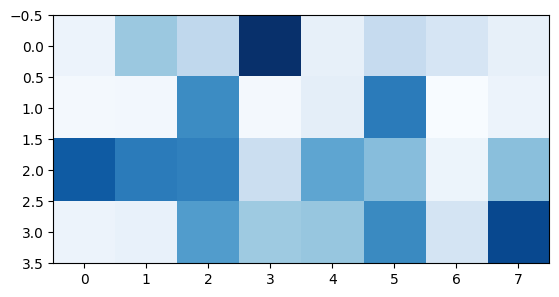

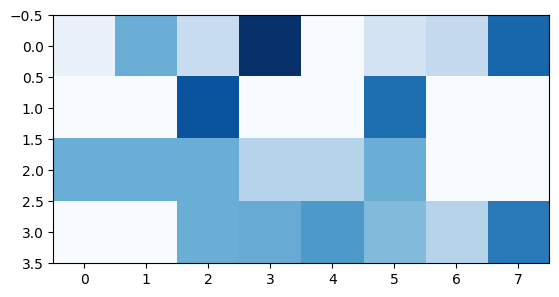

In [33]:
# plot prediction
# mel_img, label = train_set.__getitem__(200)
# mel_img = mel_img.reshape(1, 1, 224, 224)
# mel_img = torch.tensor(mel_img).type(torch.cuda.FloatTensor)

# reconstructed_parameters, mu, logvar = model(mel_img)
# reconstructed_parameters= model(mel_img)
# reconstructed_parameters = reconstructed_parameters.cpu().detach().numpy()
# prediction = reconstructed_parameters.reshape(4, 8)
# label = label.reshape(4, 8)
# plt.figure(1)
# plt.imshow(prediction, cmap='Blues')
# plt.figure(2)
# plt.imshow(label, cmap='Blues')

CNN_evaluate(model, val_set, 100)

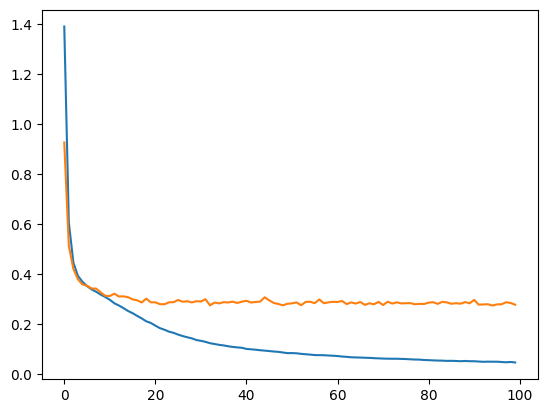

In [29]:
# plot losses
plt.plot(result[0, :])
plt.plot(result[1, :])

In [ ]:
import torch.nn.functional as F

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

model.eval()
model.to(device)
total_loss = 0
total_samples = 0

with torch.no_grad():
    for inputs, targets in dataloader:
        inputs, targets = inputs.type(torch.float32).to(device), targets.type(torch.float32).to(device)
        outputs = model(inputs)
        loss = F.mse_loss(outputs, targets)
        total_loss += loss.item() * inputs.size(0)
        total_samples += inputs.size(0)

mse_loss = (total_loss / total_samples)

return mse_loss


In [ ]:
test_model(model, test_set, "cuda")